In [6]:
import os
# Set environment variables to disable multithreading as users will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
###############################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [7]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sdss.metadata import MetaData
from autoencoders.ae import AutoEncoder


meta = MetaData()
%matplotlib inline

In [3]:
def specobjid_to_idx(specobjid: int, ids: np.array):
    mask = np.where(ids[:, 1]==specobjid, True, False)
    idx = int(ids[mask, 0][0])
    return idx

In [11]:
bin_id = "bin_04"
model_id = "0013"
architecture = "256_128_64/latent_12"

meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
scores_directory = f"{meta_data_directory}/{bin_id}/explanation/{architecture}"
model_directory = f"{meta_data_directory}/{bin_id}/models/{architecture}"

In [12]:
wave = np.load(f"{meta_data_directory}/wave.npy")
spectra = np.load(f"{meta_data_directory}/spectra.npy", mmap_mode="r")
ids = np.load(f"{meta_data_directory}/ids_inputting.npy")

model = AutoEncoder(
    reload=True,
    reload_from=f"{model_directory}/{model_id}"
)

In [42]:
scores_names = {
    "correlation": "Correlation score",
    "correlation_filter_250kms": "Correlation score with a 250 kms filter",
    "cosine": "Cosine disimilarity score",
    "cosine_filter_250kms": "Cosine disimilarity score with a 250 kms filter",
    "lp_noRel100": "lp score",
    "lp_filter_250kms_noRel100": "lp score with a 250 kms filter",
    "lp_noRel97": "lp score ignoring 3% of largest residuals",
    "lp_filter_250kms_noRel97": "lp score ignoring 3% of largest residuals with a 250 kms filter",
    "lp_rel100": "lp relative score",
    "lp_filter_250kms_rel100": "lp relative score with a 250 kms filter",
    "lp_rel97": "lp relative score\n ignoring 3% of largest residuals",
    "lp_filter_250kms_rel97": "lp relative score ignoring 3% of largest residuals with a 250 kms filter",
}

# df_scores = {}
set_scores_index = {}
anomalies = {}

for metric in scores_names.keys():
    
    specobjids = pd.read_csv(
        f"{scores_directory}/{metric}/top_anomalies.csv.gz",
        index_col="specobjid",
    ).index[-50:]
    
    set_scores_index[metric] = set(specobjids)
    
    anomalies[metric] = np.load(
        f"{scores_directory}/{metric}/top_anomalies.npy",
        mmap_mode="r"
    )

# Lp scores

### Filters

In [45]:
def plot_compare():
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, tight_layout=True)

    axs[1].set_xlabel("$\lambda [\AA]$")
    axs[0].set_ylabel("Median normalized flux")
    axs[1].set_ylabel("Residual")

    return fig, axs

def compare(spectra_idx):
    observation = spectra[spectra_idx]
    reconstruction = model.reconstruct(observation).reshape(-1)
    residual = np.abs(observation-reconstruction)

    return observation, reconstruction, residual


In [53]:
lp_filter = ["lp_noRel100", "lp_filter_250kms_noRel100"]
intersection_set = set_scores_index["lp_noRel100"]

for metric in lp_filter:

    intersection_set = intersection_set.intersection(
        set_scores_index[metric]
    )
print("intersection len:", len(intersection_set))

diff_in_filter = set_scores_index["lp_filter_250kms_noRel100"].difference(
    intersection_set
)

diff_in_no_filter = set_scores_index["lp_noRel100"].difference(
    intersection_set
)

print(len(diff_in_filter), len(diff_in_no_filter))

idxs_no_filter = []
for specobjid in diff_in_no_filter:
    idx = specobjid_to_idx(specobjid=specobjid, ids=ids)
    idxs_no_filter.append([idx, specobjid])

idxs_filter = []
for specobjid in diff_in_filter:
    idx = specobjid_to_idx(specobjid=specobjid, ids=ids)
    idxs_filter.append([idx, specobjid])


intersection len: 47
3 3


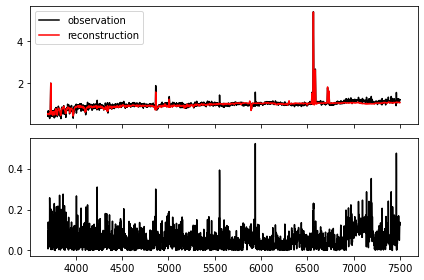

In [54]:
observation, reconstruction, residual = compare(idxs_filter[0][0])

fig, axs = plot_compare()

for ax in axs: ax.clear()

axs[0].plot(wave, observation, c="black", label="observation")
axs[0].plot(wave, reconstruction, c="red", label="reconstruction")
axs[0].legend()

axs[1].plot(wave, residual, c="black")

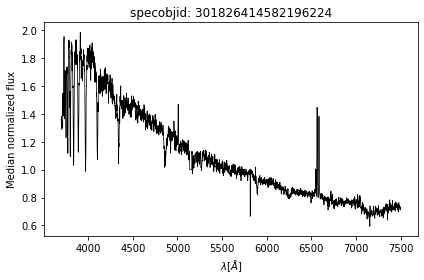

In [56]:
save_to = "/home/edgar/explain-me-why/sections/figures/score/lp/filter"
fig, ax = plt.subplots(tight_layout=True)

for idx_id in idxs_no_filter:
    
    specobjid = idx_id[1]

    ax.clear()

    ax.title.set_text(f"specobjid: {specobjid}")

    ax.set_xlabel("$\lambda [\AA]$")
    ax.set_ylabel("Median normalized flux")

    ax.plot(
        wave, spectra[idx_id[0]],
        color="black", #label=f"specobjid: {specobjid}"
        lw=0.75
    )
    plot_name = f"lp_{idx_id[0]}"
    # fig.savefig(f"{save_to}/{plot_name}.png")
    fig.savefig(f"{save_to}/{plot_name}.pdf")

for idx_id in idxs_filter:
    
    specobjid = idx_id[1]

    ax.clear()

    ax.title.set_text(f"specobjid: {specobjid}")

    ax.set_xlabel("$\lambda [\AA]$")
    ax.set_ylabel("Median normalized flux")

    ax.plot(
        wave, spectra[idx_id[0]],
        color="black", #label=f"specobjid: {specobjid}"
        lw=0.75
    )
    plot_name = f"lp_filter_{idx_id[0]}"
    # fig.savefig(f"{save_to}/{plot_name}.png")
    fig.savefig(f"{save_to}/{plot_name}.pdf")